In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install gdown

In [2]:
!gdown --id 1Oce8YZMauJoEDmiXzeCoS1NyvGyE3b3a

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Oce8YZMauJoEDmiXzeCoS1NyvGyE3b3a
From (redirected): https://drive.google.com/uc?id=1Oce8YZMauJoEDmiXzeCoS1NyvGyE3b3a&confirm=t&uuid=ba38d38b-73a1-4b15-bb18-4ce9a4ceb699
To: /kaggle/working/test_dataset.rar
100%|███████████████████████████████████████| 1.42G/1.42G [00:11<00:00, 125MB/s]


In [3]:
!apt install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 72 not upgraded.
Need to get 145 kB of archives.
After this operation, 339 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 unrar amd64 1:6.1.5-1 [145 kB]
Fetched 145 kB in 0s (765 kB/s)

78Selecting previously unselected package unrar.
(Reading database ... 122997 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a6.1.5-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking unrar (1:6.1.5-1) ...
7Progress: [ 40%] [#######################...................................] 8Setting up unrar (1:6.1.5-1) ...
7Progress: [ 60%] [##################################..............

In [4]:
!unrar x /kaggle/working/test_dataset.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /kaggle/working/test_dataset.rar

Creating    final_dataset                                             OK
Creating    final_dataset/built_up                                    OK
Creating    final_dataset/built_up/input                              OK
Extracting  final_dataset/built_up/input/output_tile_0_3.tif             0  OK 
Extracting  final_dataset/built_up/input/output_tile_1_1.tif             1  OK 
Extracting  final_dataset/built_up/input/output_tile_1_2.tif               2  OK 
Extracting  final_dataset/built_up/input/output_tile_1_3.tif               3  OK 
Extracting  final_dataset/built_up/input/output_tile_2_0.tif             3  OK 
Extracting  final_dataset/built_up/input/output_tile_2_1.tif               4  OK 
Extracting  final_dataset/built_up/input/output_tile_2_2.tif               5  OK 
Extracting  final_dataset/built_up/input/output_tile_2_3.tif               6  OK 
Extra

## Multi-Class Image Segmentation

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
input_folder = "/kaggle/working/final_dataset/roads/input"
mask_folder = "/kaggle/working/final_dataset/roads/output"
image_size = (256, 256)  # Resize for training

In [ ]:
# Color to Class Mapping
COLOR_MAP = {
    (0, 0, 0): 0,       # Background/No Data
    (255, 0, 0): 1,     # Roads
    (0, 0, 255): 2,     # Water Bodies
    (0, 128, 0): 3,     # RCC Rooftop
    (255, 255, 0): 4,   # Tin Rooftop
    (255, 0, 255): 5,   # Tiled Rooftop
    (165, 42, 42): 6    # Other Rooftops
}


In [ ]:
# Functions
def rgb_to_class(mask):
    """Convert RGB mask to class indices."""
    mask_class = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for rgb, class_idx in COLOR_MAP.items():
        mask_class[(mask == rgb).all(axis=-1)] = class_idx
    return mask_class

def preprocess_data(image_path, mask_path):
    """Load and preprocess images and masks."""
    images, masks = [], []
    for filename in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, filename))
        img = cv2.resize(img, image_size)
        images.append(img)
        
        mask = cv2.imread(os.path.join(mask_path, filename))
        mask = cv2.resize(mask, image_size)
        mask_class = rgb_to_class(mask)
        masks.append(mask_class)
        
    return np.array(images), np.array(masks)


In [ ]:
# Load Data
images, masks = preprocess_data(input_folder, mask_folder)

# One-hot encode masks
masks = to_categorical(masks, num_classes=len(COLOR_MAP))

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [ ]:
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model


In [ ]:
# Compile Model
model = unet_model((image_size[0], image_size[1], 3), len(COLOR_MAP))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=25
)


In [ ]:
model.save("segmentation_model.h5")

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Paths
model_path = "segmentation_model.h5"
test_images_folder = "path/to/test/images"
output_folder = "path/to/save/results"

# Load the Trained Model
model = tf.keras.models.load_model(model_path)

In [ ]:
# Color Table for Visualization
COLOR_MAP = {
    0: (0, 0, 0),       # Background/No Data
    1: (255, 0, 0),     # Roads
    2: (0, 0, 255),     # Water Bodies
    3: (0, 128, 0),     # RCC Rooftop
    4: (255, 255, 0),   # Tin Rooftop
    5: (255, 0, 255),   # Tiled Rooftop
    6: (165, 42, 42)    # Other Rooftops
}

# Reverse Map for Visualization
CLASS_TO_RGB = {class_idx: color for class_idx, color in COLOR_MAP.items()}

In [ ]:
# Preprocessing Function
def preprocess_image(image_path, target_size=(256, 256)):
    """Resize and normalize the image for model prediction."""
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0  # Normalize to [0, 1]
    return img_normalized, img_resized  # Return resized for visualization

# Postprocessing Function
def class_to_rgb(prediction):
    """Convert class indices to RGB colors."""
    rgb_image = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    for class_idx, color in CLASS_TO_RGB.items():
        rgb_image[prediction == class_idx] = color
    return rgb_image

# Inference and Visualization
def infer_and_visualize(image_path, model, target_size=(256, 256)):
    """Perform inference on an image and visualize the results."""
    # Preprocess the input image
    preprocessed_img, original_img = preprocess_image(image_path, target_size)
    input_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension

    # Perform Prediction
    prediction = model.predict(input_img)
    prediction = np.argmax(prediction[0], axis=-1)  # Get class indices

    # Convert to RGB
    predicted_rgb = class_to_rgb(prediction)

    # Resize predicted mask to match original image size
    predicted_rgb_resized = cv2.resize(predicted_rgb, (original_img.shape[1], original_img.shape[0]))

    # Visualization
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_rgb_resized)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    overlay = cv2.addWeighted(original_img, 0.6, predicted_rgb_resized, 0.4, 0)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Batch Processing for Test Images
def batch_infer_and_save(test_folder, model, output_folder, target_size=(256, 256)):
    """Process all images in the test folder, save predicted masks."""
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(test_folder):
        image_path = os.path.join(test_folder, filename)
        preprocessed_img, original_img = preprocess_image(image_path, target_size)

        # Perform Prediction
        input_img = np.expand_dims(preprocessed_img, axis=0)
        prediction = model.predict(input_img)
        prediction = np.argmax(prediction[0], axis=-1)

        # Convert to RGB
        predicted_rgb = class_to_rgb(prediction)

        # Resize predicted mask to match original image size
        predicted_rgb_resized = cv2.resize(predicted_rgb, (original_img.shape[1], original_img.shape[0]))

        # Save the result
        output_path = os.path.join(output_folder, f"predicted_{filename}")
        cv2.imwrite(output_path, predicted_rgb_resized)

        print(f"Saved: {output_path}")

In [ ]:
# Example Usage
test_image_path = "path/to/test/image.jpg"  # Path to a single test image
infer_and_visualize(test_image_path, model)

# Batch process all test images
batch_infer_and_save(test_images_folder, model, output_folder)

## Binary Segmentation

In [5]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-dlq0tphi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-dlq0tphi
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59

In [6]:
# File: water_body_segmentation_detectron2.py

import os
import cv2
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
import json
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer

In [7]:
def convert_tif_to_coco_format(image_dir, mask_dir, output_json):
    """
    Converts the TIF dataset into COCO format.
    Args:
        image_dir: Path to the directory containing input TIF images.
        mask_dir: Path to the directory containing corresponding binary mask images.
        output_json: Path to save the COCO formatted annotations.
    """
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "water_body"}]
    }
    annotation_id = 0

    for idx, filename in enumerate(os.listdir(image_dir)):
        if filename.endswith(".tif"):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename)

            # Load the image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Add image entry
            image_id = idx
            coco_format["images"].append({
                "id": image_id,
                "file_name": filename,
                "width": image.shape[1],
                "height": image.shape[0]
            })

            # Extract contours from the binary mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                segmentation = contour.flatten().tolist()
                if len(segmentation) < 6:  # Ignore small contours
                    continue
                x, y, w, h = cv2.boundingRect(contour)

                # Add annotation entry
                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 1,
                    "bbox": [x, y, w, h],
                    "area": w * h,
                    "segmentation": [segmentation],  # Polygon segmentation
                    "iscrowd": 0
                })
                annotation_id += 1

    # Save COCO formatted JSON
    with open(output_json, 'w') as f:
        json.dump(coco_format, f, indent=4)

In [8]:
DatasetCatalog.pop("water_body_train", None)
MetadataCatalog.pop("water_body_train", None)

In [9]:
# Paths
image_dir = "/kaggle/working/final_dataset/water_bodies/input"
mask_dir = "/kaggle/working/final_dataset/water_bodies/output"
output_json = "/kaggle/working/annotations.json"

# Convert dataset
convert_tif_to_coco_format(image_dir, mask_dir, output_json)

# Register the dataset
register_coco_instances("water_body_train", {}, output_json, image_dir)
road_metadata = MetadataCatalog.get("water_body_train")
#DatasetCatalog.get("water_body_train")

In [10]:
!git clone "https://github.com/facebookresearch/detectron2.git"

Cloning into 'detectron2'...
remote: Enumerating objects: 15819, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 15819 (delta 31), reused 47 (delta 17), pack-reused 15743 (from 1)
Receiving objects: 100% (15819/15819), 6.38 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (11527/11527), done.


In [11]:
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T

def custom_mapper(dataset_dict):
    # Apply custom augmentations
    dataset_dict = DatasetMapper(
        is_train=True,
        augmentations=[
            T.Resize((512, 512)),  # Resize to a consistent size
            T.RandomFlip(horizontal=True, vertical=False),  # Horizontal flip
            T.RandomBrightness(0.9, 1.1),  # Random brightness
            T.RandomContrast(0.9, 1.1),  # Random contrast
        ],
        image_format="BGR",
    )(dataset_dict)
    return dataset_dict

In [12]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T

def get_cfg_for_training(output_dir, num_classes=1):
    """
    Configures Detectron2 for training.
    """
    cfg = get_cfg()
    cfg.merge_from_file("/kaggle/working/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
    cfg.DATASETS.TRAIN = ("water_body_train",)
    cfg.DATASETS.TEST = ()  # No test set for now
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl"  # Pretrained model

    # Optimizer and schedule
    cfg.SOLVER.IMS_PER_BATCH = 2  # Adjusted for 1 GPU (reduce batch size)
    cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
    cfg.SOLVER.MAX_ITER = 3000  # More iterations
    cfg.SOLVER.WARMUP_ITERS = 500
    cfg.SOLVER.STEPS = [1500, 2500]  # Decay learning rate

    # Model settings
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes  # One class (building)
    cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION = 28  # Higher resolution masks
    cfg.MODEL.ROI_MASK_HEAD.POOLER_SAMPLING_RATIO = 2
    cfg.MODEL.ROI_MASK_HEAD.CONV_DIM = 256

    # Output directory
    cfg.OUTPUT_DIR = output_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg


output_dir = "./water_body_segmentation_output"
cfg = get_cfg_for_training(output_dir)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

X-101-32x8d.pkl: 356MB [00:01, 272MB/s]                               
/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
import cv2
import numpy as np
import torch

def mask_to_polygon(mask):
    """
    Converts binary mask to polygons with straight edges using contour approximation.
    Args:
        mask: Binary mask array.
    Returns:
        Approximated polygon mask.
    """
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    approximated_mask = np.zeros_like(mask)

    for contour in contours:
        # Approximate the polygon
        epsilon = 0.01 * cv2.arcLength(contour, True)  # Adjust epsilon for tighter curves
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # Draw the approximated polygon back onto the mask
        cv2.drawContours(approximated_mask, [approx], -1, 1, thickness=cv2.FILLED)

    return approximated_mask

def perform_inference_with_polygon_postprocessing(cfg, image_path):
    """
    Perform inference on a single image with polygon-based post-processing.
    Args:
        cfg: Configured Detectron2 config object.
        image_path: Path to the image for inference.
    """
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set threshold for this model
    predictor = DefaultPredictor(cfg)

    # Load image
    image = cv2.imread(image_path)
    outputs = predictor(image)  # Perform prediction

    # Apply polygon-based post-processing to each predicted mask
    instances = outputs["instances"]
    for i, mask in enumerate(instances.pred_masks):
        # Convert mask to numpy for processing
        mask_array = mask.cpu().numpy().astype(np.uint8)

        # Apply polygon approximation
        refined_mask = mask_to_polygon(mask_array)

        # Convert back to tensor and update predictions
        instances.pred_masks[i] = torch.tensor(refined_mask, dtype=torch.bool)

    # Visualize
    v = Visualizer(
        image[:, :, ::-1], 
        metadata=road_metadata, 
        scale=1.2, 
        instance_mode=ColorMode.IMAGE  # For instance masks
    )
    v = v.draw_instance_predictions(instances.to("cpu"))
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

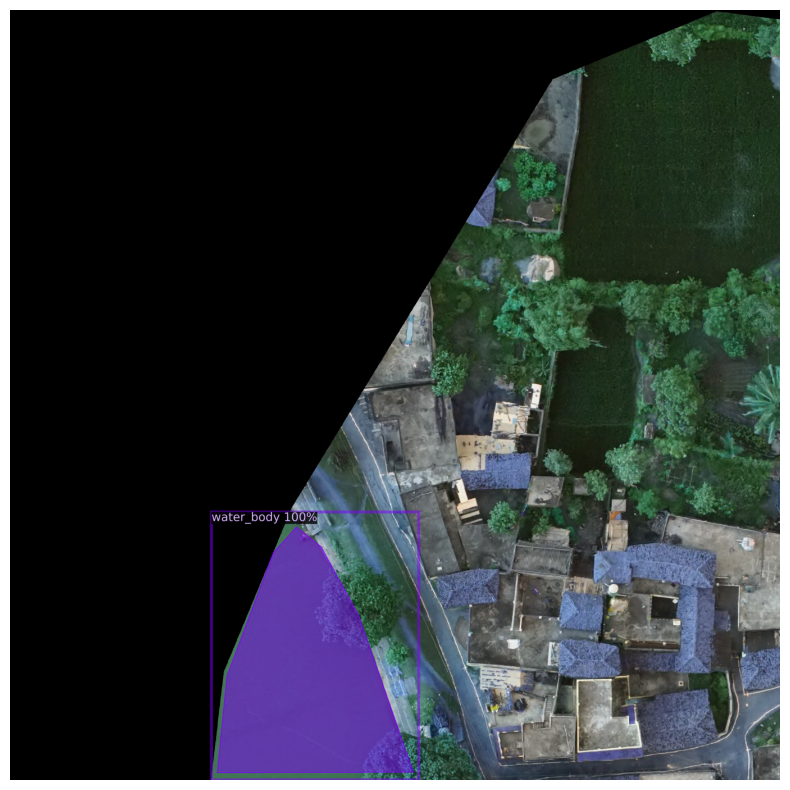

In [17]:
# Perform inference
test_image_path = "/kaggle/working/final_dataset/water_bodies/input/amirpur_output_tile_0_0.tif"
perform_inference_with_polygon_postprocessing(cfg, test_image_path)

/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

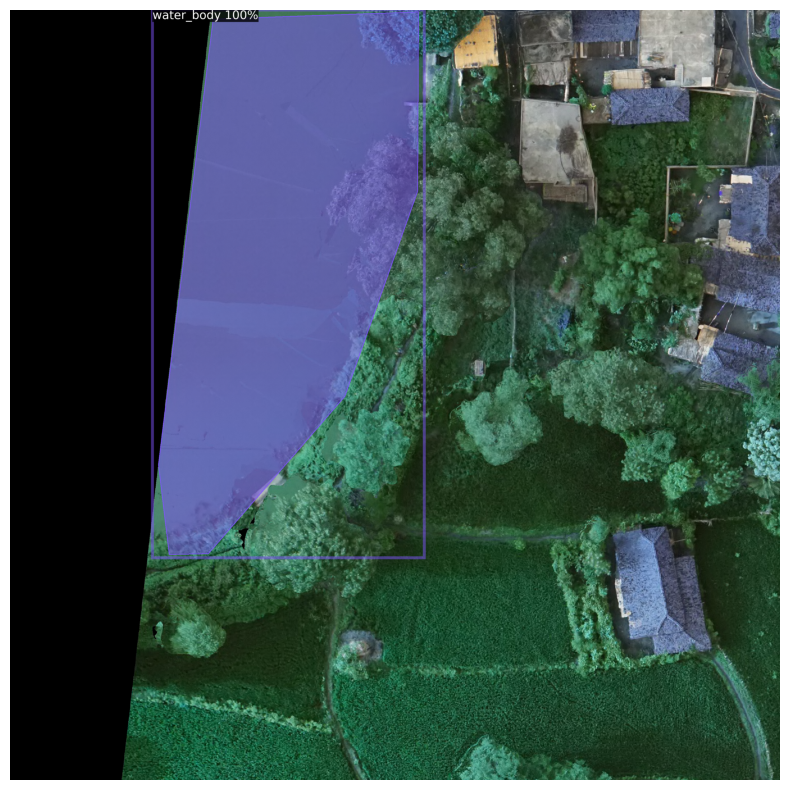

In [18]:
# Perform inference
test_image_path = "/kaggle/working/final_dataset/water_bodies/input/amirpur_output_tile_1_0.tif"
perform_inference_with_polygon_postprocessing(cfg, test_image_path)

In [ ]:
test_image_path = "/kaggle/working/final_dataset/built_up/input/output_tile_2_2.tif"
perform_inference(cfg, test_image_path)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Perform Evaluation
def evaluate_model(cfg):
    """
    Evaluate the trained model using COCOEvaluator.
    Args:
        cfg: The Detectron2 configuration object.
    """
    # Create COCO Evaluator
    evaluator = COCOEvaluator("road_train", cfg, False, output_dir=cfg.OUTPUT_DIR)

    # Build the test data loader
    val_loader = build_detection_test_loader(cfg, "road_train")

    # Run inference and evaluate
    print("Evaluating the model...")
    results = inference_on_dataset(trainer.model, val_loader, evaluator)
    print("Evaluation Results:\n", results)

# Call the evaluation function
evaluate_model(cfg)

In [19]:
!zip -r /kaggle/working/water_body_segmentation_detectron_checkpoint.zip /kaggle/working/water_body_segmentation_output

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/water_body_segmentation_output/ (stored 0%)
  adding: kaggle/working/water_body_segmentation_output/metrics.json (deflated 80%)
  adding: kaggle/working/water_body_segmentation_output/events.out.tfevents.1733987568.73c10554055c.23.0 (deflated 73%)
  adding: kaggle/working/water_body_segmentation_output/last_checkpoint (stored 0%)
  adding: kaggle/working/water_body_segmentation_output/model_final.pth (deflated 7%)
